In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special
import scipy.ndimage
import scipy.optimize
import sklearn.datasets

from chmp.ds import mpl_set, get_color_cycle, Loop

In [4]:
# helper for gradient checking
def approximate_gradient(x, func, eps=1e-5):
    res = np.zeros(x.size)
    
    for i in range(x.size):
        d = np.zeros(x.size)
        d[i] = eps
        
        res[i] = (func(x + d) - func(x - d)) / (2 * eps)
    
    return res

# Kernel Methods

## Dual Representations

$$
\begin{align}
    J 
    &= \frac{1}{2} \sum_n \left( w^T \phi(x_n) - t_n \right)^2 + \frac{\lambda}{2} w^T w
\\
    &= \frac{1}{2} \left( \Phi w - t  \right)^T \left( \Phi w - t \right) + \frac{\lambda}{2} w^T w
\end{align}
$$

with $\Phi_{ni} = \phi_i(x_n)$. Further define $w = \Phi^T a$. That this is always possible can be shown, by differentiating $J$ with respect to $w$. At optimality one finds:

$$
\begin{align}
    0 &= \left( w^T \Phi^T - t^T \right) \Phi + \lambda w \\
    w &= -\frac{1}{\lambda} \left( w^T \Phi^T - t^T \right) \Phi \\
    w &= -\frac{1}{\lambda} \Phi^T \left( \Phi w - t \right) \\
    w &= \Phi^T a
\end{align}
$$

Inserting $w = \Phi^T a$ into the objective function results in:

$$
\begin{align}
    J 
    &= 
        \frac{1}{2} \left( \Phi \Phi^T a - t  \right)^T \left( \Phi \Phi^T a - t \right) + 
        \frac{\lambda}{2} a^T \Phi \Phi^T a
\\
    &= 
        \frac{1}{2} a^T \Phi \Phi^T \Phi \Phi^T  a -
        a^T \Phi \Phi^T t +
        \frac{1}{2} t^T t +
        \frac{\lambda}{2} a^T \Phi \Phi^T a
\\
    &= 
        \frac{1}{2} a^T K K  a - a^T K t + \frac{1}{2} t^T t + \frac{\lambda}{2} a^T K a
\end{align}
$$

with $K = \Phi \Phi^T$. Searching for the optimal $a$ yields

$$
\begin{align}
    0 &= K K  a - K t + \lambda K a \\
    0 &= K ((K + \lambda) a - t) \\
    a &= (K + \lambda)^{-1} t
\end{align}
$$

Note, that $K$ has the form:

$$
    K_{mn} = \sum_i \phi_i(x_m) \phi_i(x_n) = k(x_m, x_n).
$$

Now, the number size of the problem depends only on the number of training examples, not the number of features. This allows to introduce abitrary many features, even infinitely many via kernels.

The predicted values are given by

$$
\begin{align}
    \hat{t} &= w^T \phi(x) \\
        &= a^T \Phi \phi(x) \\
        &= \sum_{ni} a_n \phi_i(x_n) \phi_i(x) \\
        &= \sum_n a_n k(x_n, x)
\end{align}
$$

In [5]:
x, y = sklearn.datasets.make_regression(n_features=10)

K = x @ x.T
a = np.linalg.pinv(K + 1e-2) @ y
w_opt = x.T @ a

print(K.shape, a.shape, w_opt.shape)
print('mean squared error:', np.mean((y - x @ w_opt) ** 2.0))

(100, 100) (100,) (10,)
mean squared error: 2.701454169929355e-26


## Constructing Kernels

**TODO: summarize examples mentioned**

## Radial Basis Function networks

In [6]:
np.random.seed(13)
x = np.random.uniform(low=0, high=2 * np.pi, size=50)
x = np.sort(x)
y = np.random.normal(np.cos(x), scale=0.1)

u = np.linspace(0, 2 * np.pi, 100)

# build the kernel
w = np.exp(-0.5 * (u[:, None] - x[None, :]) ** 2 / (0.25))
w = w / w.sum(axis=1, keepdims=True)

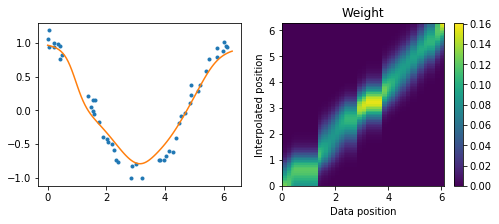

In [7]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(x, y, '.')
plt.plot(u, w @ y)

plt.subplot(1, 2, 2)
plt.pcolor(x, u, w)
mpl_set(colorbar=True, xlabel='Data position', ylabel='Interpolated position', title='Weight')

## Gaussian processes

### Regression

Basic idea: postulate covraiance structure between data points via:

$$
    p(t|\{x\}) = \mathcal{N}(t|0, C)
$$

with $C_{ij} = \beta^{-1} \delta_{ij} + k(x_i, x_j)$ with the inverse observation noise variance $\beta$.

For prediction, use the same structure for the joint $p(t_{n+1}, \{t\}|x_{n+1}, \{x\}) = \mathcal{N}(t| 0, C) $ and compute the conditional:

$$
\begin{align}
    p(t_{n+1}|\{t\}, \{x\}) &= \mathcal{N}(t_{n+1}|m_{n+1}, \sigma_{n+1}), \\
    m_{n+1} &= k^T C_N^{-1} t, \\
    \sigma_{n+1} &= c - k^T C_N^{-1} k,
\end{align}
$$

where $C_N, k, c$ form the full covariance matrix as in

$$
C = \begin{pmatrix}
    C_N & k^T \\
    k & c
\end{pmatrix}.
$$


In [8]:
k = np.exp(-1 * abs(x[:, None] - x[None, :]))

In [9]:
s = np.real(scipy.linalg.sqrtm(k))

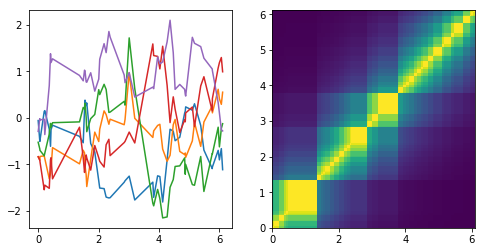

In [10]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
for _ in range(5):
    plt.plot(x, s @ np.random.normal(size=s.shape[0]))

plt.subplot(1, 2, 2)
plt.pcolor(x, x, k)

In [249]:
np.random.seed(13)
x = np.random.uniform(low=0, high=2 * np.pi, size=50)
x = np.sort(x)
y = np.random.normal(np.cos(x), scale=0.1)

In [250]:
xi = np.linspace(0, 2 * np.pi, 100)

In [251]:
alpha = 0.25
beta = 10.

In [261]:
c_N = (1.0 / beta) * np.eye(x.size) + np.exp(-alpha * abs(x[:, None] - x[None, :]) ** 2.0) 
k = np.exp(-alpha * abs(x[:, None] - xi[None, :]) ** 2.0)
c = (1.0 / beta) + np.diag(np.exp(-alpha * abs(xi[:, None] - xi[None, :]) ** 2.0))

In [262]:
m = k.T @ np.linalg.pinv(c_N) @ y
s = c - np.diag(k.T @ np.linalg.pinv(c_N) @ k)

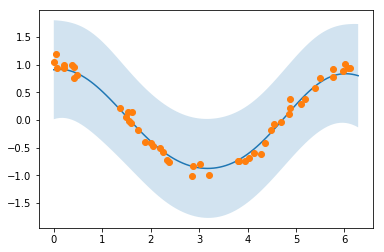

In [263]:
plt.plot(xi, m)
plt.fill_between(xi, m - np.sqrt(s), m + np.sqrt(s), alpha=0.2)
plt.plot(x, y, 'o')

The hyperparameters (here, $\alpha, \beta$) can for example be optimized by maximum likelihood. The log likelihood of the data is given by

$$
    \mathcal{L} = \log p(\{t\}| \{x\}) = -\frac{1}{2} |C_N| - \frac{1}{2} t^T C_N^{-1} t - \frac{N}{2} \log 2 \pi
$$

By using different lengthscales for different dimensions of $x$, automatic relevance determination can be implemented.

In [259]:
def loglikelihood(params):
    alpha, beta = params
    alpha = np.log(1 + np.exp(alpha))
    beta = np.log(1 + np.exp(beta))
    c_N = (1.0 / beta) * np.eye(x.size) + np.exp(-alpha * abs(x[:, None] - x[None, :]) ** 2.0) 
    return (y.T @ np.linalg.pinv(c_N) @ y + np.linalg.det(c_N)) / x.size


def fit_gp_params():
    res = scipy.optimize.minimize(loglikelihood, [0, 0])
    if not res.success:
        raise RuntimeError(res.message)
    return np.log(1 + np.exp(res.x))
    

In [260]:
alpha, beta = fit_gp_params()
print(alpha, beta)

0.5649704149113319 1.4485272009115577


### Classification

Define probability of target in terms of logits $a$:

$$
    p(t|a) = \sigma(a)^t (1 - \sigma)^{(1 - t)}
$$

Assume the logits are distributed according to a Gaussian process:

$$
\begin{align}
    a &\sim \mathcal{GP} \\
    p(a) &= \mathcal{N}(a|0, C)
\end{align}
$$

Divide the covariance matrix into:

$$
    C_{m,n} = k(x_m, x_n) + \nu \delta_{mn}
$$

Now introduce a fully observed set $\{x, t\}$ and make a prediction for a new point $x_{N + 1}$

The new logits are distributed according to:

$$
    p(a_{N+1}|\{x, t\}) = \int \mathrm{d}a_N\; p(a_{N+1}|a_N) p(a_N|\{x, t\})
$$

Further:

$$
\begin{align}
    \log p(a_N|\{x, t\}) 
    &= \log p(\{t\}|a_N) + \log p(a_N|\{x\}) + \mathrm{const}
\\
    &= 
        -\frac{1}{2} a_N^T C_N^{-1} a_N + 
        \sum_n t_n \log \sigma(a_n) +
        \sum_n (1 - t_n) \log (1 - \sigma(a_n))
\end{align}
$$

This density is intractable to compute. Use Laplace approximation:

$$
\begin{align}
    \frac{\partial}{\partial a_{Ni}} \log p(a_N|\{x, t\}) 
    &= - \sum_j C_{Nij}^{-1} a_j + t_i (1 - \sigma(a_i)) - (1 - t_i) \sigma(a_i)
\\
    &= - \sum_j C_{Nij}^{-1} a_j + t_i - \sigma(a_i)
\\
    \frac{\partial^2}{\partial a_{Ni} \partial a_{Nj}} \log p(a_N|\{x, t\}) 
    &= - C_{Nij}^{-1} - \sigma(a_i) (1 - \sigma(a_i)) \delta_{ij}
\end{align}
$$

Given the Laplace approximation $p(a_{N+1}|\{x, t\})$ can be evaluated.

In [243]:
# TODO: implement